This notebook implements the machine learning models.


In [1]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, balanced_accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

**Define functions**

In [2]:
def create_labels(df):
    '''
    change the labels, control and IBD, to 0 and 1
    '''
    y = [-1] * len(df)

    for i in range(0, len(df)):
        if df.loc[i][2] == "IBD":
            y[i] = 1
        else:
            y[i] = 0
    return y

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based on the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.legend([f'AUC = {round(roc_auc_score(true_y, y_prob), 2)}'], loc='upper left')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


def svm_search_params(x, y):
    """
    finds parameters for svm classifier with grid search and returns the best model

    :param x: scaled train data
    :param y: train labels
    :return: SVM classifier with best parameters
    """

    # SVM model
    svc_clf = SVC(kernel='rbf')

    # set up the search grid for parameter values: regularization parameter C and gamma
    param_grid = {'C': [2**j for j in range(-5, 10, 2)], 'gamma': [2**j for j in range(-15, 3, 2)]}

    # perform grid search cross-validation (stratified (target variable) 5-fold) to find the best parameters
    grid_search = GridSearchCV(svc_clf, param_grid, cv=5)
    grid_search.fit(x,y)
    print("Best parameters SVM: ", grid_search.best_params_)
    print("Best score SVM: ", grid_search.best_score_)

    # return best model
    svc_opt = grid_search.best_estimator_

    return svc_opt

def rf_search_params(x, y):
    """
    finds parameters for random forest classifier with grid search and returns the best model

    :param x: scaled train data
    :param y: train labels
    :return: RF classifier with best parameters
    """

    # random forest model
    clf = RandomForestClassifier(kernel='rbf')

    # set up the search grid for parameter values: regularization parameter C and gamma
    param_grid = {'C': [2**j for j in range(-5, 10, 2)], 'gamma': [2**j for j in range(-15, 3, 2)]}

    # perform grid search cross-validation (stratified (target variable) 5-fold) to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(x,y)
    print("Best parameters Random Forest: ", grid_search.best_params_)
    print("Best score Random Forest: ", grid_search.best_score_)

    # return best model
    rf_opt = grid_search.best_estimator_

    return rf_opt

def lr_search_params(x, y):
    """
    finds parameters for logistic regression classifier with grid search and returns the best model

    :param x: scaled train data
    :param y: train labels
    :return: lr classifier with best parameters
    """

    # random forest model
    clf = LogisticRegression(penalty='elasticnet')

    # set up the search grid for parameter values: regularization parameter C and gamma
    param_grid = {'C': [2**j for j in range(-5, 10, 2)], 'gamma': [2**j for j in range(-15, 3, 2)]}

    # perform grid search cross-validation (stratified (target variable) 5-fold) to find the best parameters
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(x,y)
    print("Best parameters Logistic Regression: ", grid_search.best_params_)
    print("Best score Logistic Regression: ", grid_search.best_score_)

    # return best model
    lr_opt = grid_search.best_estimator_

    return lr_opt


**Load data**

In [6]:
# define path to dataset
path = 'relative_abundance_NielsenVilaLi.csv'
df = pd.read_csv(path)
df.head(10)

,Unnamed: 0,study_name,study_condition,subject_id,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_plebeius,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Lachnospiraceae_unclassified.s__Eubacterium_rectale,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcaceae_unclassified.s__Eubacterium_siraeum,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcus.s__Ruminococcus_bicirculans,...,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellia_unclassified.f__Tissierellia_unclassified.g__Tissierellia_unclassified.s__Bacteroides_coagulans,k__Bacteria.p__Actinobacteria.c__Coriobacteriia.o__Eggerthellales.f__Eggerthellaceae.g__Slackia.s__Slackia_exigua,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_casseliflavus,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Veillonella.s__Veillonella_seminalis,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Peptostreptococcaceae.g__Clostridioides.s__Clostridioides_difficile,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Lactobacillaceae.g__Lactobacillus.s__Lactobacillus_pentosus,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellales.f__Peptoniphilaceae.g__Peptoniphilus.s__Peptoniphilus_lacrimalis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_agalactiae,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Gemmiger.s__Gemmiger_sp_An50,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_durans
0,0,LiJ_2014,control,MH0290,0.00000,0.00000,4.63364,3.26718,0.15616,0.12213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,LiJ_2014,control,MH0336,0.00000,0.00000,1.20573,1.38979,0.01259,0.08489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,LiJ_2014,control,MH0340,0.00000,3.25987,2.82635,0.03563,13.49471,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,LiJ_2014,control,NLF002-IE,0.00000,0.00000,8.59539,0.00000,0.00000,0.34296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,LiJ_2014,control,NLF009-IE,0.00000,1.83114,12.42438,1.78118,0.17359,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,LiJ_2014,control,NLM009-IE,0.00300,0.00030,3.84071,0.93718,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,LiJ_2014,control,NLM025-IE,2.69577,0.73295,8.30463,1.43917,0.00000,0.71147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,LiJ_2014,control,NOF002-IE,0.00046,0.00000,2.51783,0.00081,0.00000,0.30936,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,LiJ_2014,control,NOF007-IE,0.01132,1.78422,5.89003,0.00704,0.00000,0.24896,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,LiJ_2014,control,NOF013-IE,0.00000,0.00000,6.51111,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# create y and x
y = np.array(create_labels(df))
x = df.iloc[:, 4:]
print("x shape: ", x.shape, ", y shape: ", y.shape)

# split data to train and test sets
trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# set up scaler
scaler = StandardScaler()

# fit using only train data
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

print("Train set: IBD => ", np.sum(trainY), ", control => ", trainY.shape[0]-np.sum(trainY))
print("Test set: IBD => ", np.sum(testY), ", control => ", testY.shape[0]-np.sum(testY))

# now the first four columns are removed
x.head(10)

x shape:  (901, 454) , y shape:  (901,)
Train set: IBD =>  514 , control =>  206
Test set: IBD =>  129 , control =>  52


,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_plebeius,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_caccae,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Faecalibacterium.s__Faecalibacterium_prausnitzii,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Lachnospiraceae_unclassified.s__Eubacterium_rectale,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcaceae_unclassified.s__Eubacterium_siraeum,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Ruminococcus.s__Ruminococcus_bicirculans,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Lachnospiraceae.g__Coprococcus.s__Coprococcus_eutactus,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_coprocola,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_uniformis,k__Bacteria.p__Bacteroidetes.c__Bacteroidia.o__Bacteroidales.f__Bacteroidaceae.g__Bacteroides.s__Bacteroides_vulgatus,...,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellia_unclassified.f__Tissierellia_unclassified.g__Tissierellia_unclassified.s__Bacteroides_coagulans,k__Bacteria.p__Actinobacteria.c__Coriobacteriia.o__Eggerthellales.f__Eggerthellaceae.g__Slackia.s__Slackia_exigua,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_casseliflavus,k__Bacteria.p__Firmicutes.c__Negativicutes.o__Veillonellales.f__Veillonellaceae.g__Veillonella.s__Veillonella_seminalis,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Peptostreptococcaceae.g__Clostridioides.s__Clostridioides_difficile,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Lactobacillaceae.g__Lactobacillus.s__Lactobacillus_pentosus,k__Bacteria.p__Firmicutes.c__Tissierellia.o__Tissierellales.f__Peptoniphilaceae.g__Peptoniphilus.s__Peptoniphilus_lacrimalis,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Streptococcaceae.g__Streptococcus.s__Streptococcus_agalactiae,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Gemmiger.s__Gemmiger_sp_An50,k__Bacteria.p__Firmicutes.c__Bacilli.o__Lactobacillales.f__Enterococcaceae.g__Enterococcus.s__Enterococcus_durans
0,0.00000,0.00000,4.63364,3.26718,0.15616,0.12213,0.17455,0.0,7.97715,2.81549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.00000,1.20573,1.38979,0.01259,0.08489,0.16850,0.0,0.69553,2.12474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,3.25987,2.82635,0.03563,13.49471,0.00000,0.83849,0.0,19.61621,0.05207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.00000,8.59539,0.00000,0.00000,0.34296,0.00000,0.0,3.58186,0.06584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,1.83114,12.42438,1.78118,0.17359,0.00000,0.25043,0.0,13.11222,14.40466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00300,0.00030,3.84071,0.93718,0.00000,0.00000,0.00000,0.0,0.04164,1.28888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.69577,0.73295,8.30463,1.43917,0.00000,0.71147,0.02535,0.0,0.38862,0.40258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.00046,0.00000,2.51783,0.00081,0.00000,0.30936,0.00000,0.0,26.87201,0.00549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.01132,1.78422,5.89003,0.00704,0.00000,0.24896,0.00000,0.0,14.44849,17.14504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.00000,0.00000,6.51111,0.00000,0.00000,0.00000,0.00000,0.0,11.01043,16.81816,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Classifiers**



In [ ]:
# svm
svc = svm_search_params(trainX, trainY)
svc.fit(trainX, trainY)

Best parameters SVM:  {'C': 32, 'gamma': 0.0001220703125}
Best score SVM:  0.9013888888888889


In [ ]:
# random forest
rf = rf_search_params(trainX, trainY)
rf.fit(trainX, trainY)

In [ ]:
# logistic regression
lr = lr_search_params(trainX, trainY)
lr.fit(trainX, trainY)

In [ ]:
# predictions on test set

# svm
y_pred_svc = svc.predict(testX)
balanced_acc_svc = balanced_accuracy_score(testY, y_pred_svc)
print("SVM balanced accuracy on test set: ", balanced_acc_svc)  # average of recall obtained on each class

# random forest
y_pred_rf = rf.predict(testX)
balanced_acc_rf = balanced_accuracy_score(testY, y_pred_rf)
print("Random forest balanced accuracy on test set: ", balanced_acc_rf)

# logistic regression
y_pred_lr = lr.predict(testX)
balanced_acc_lr = balanced_accuracy_score(testY, y_pred_lr)
print("Logistic regression balanced accuracy on test set: ", balanced_acc_lr)

Accuracy on test set:  0.8950276243093923
Balanced accuracy on test set:  0.8804412641621944


In [ ]:
# print classification reports

print("SVM classification report")
print(classification_report(testY, y_pred_svc, target_names=["healthy", "IBD"]))

print("Random forest classification report")
print(classification_report(testY, y_pred_rf, target_names=["healthy", "IBD"]))

print("Logistic regression classification report")
print(classification_report(testY, y_pred_lr, target_names=["healthy", "IBD"]))


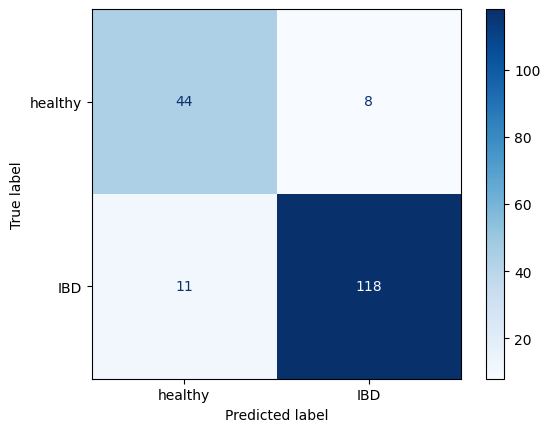

In [ ]:
# display confusion matrices

fig, ax = plt.subplots(1,3)

ax[0].set_title("SVM")
ConfusionMatrixDisplay.from_predictions(testY, y_pred_svc, display_labels=["healthy", "IBD"], cmap='Blues', ax=ax[0])

ax[0].set_title("Random Forest")
ConfusionMatrixDisplay.from_predictions(testY, y_pred_rf, display_labels=["healthy", "IBD"], cmap='Blues', ax=ax[1])

ax[0].set_title("Logistic Regression")
ConfusionMatrixDisplay.from_predictions(testY, y_pred_lr, display_labels=["healthy", "IBD"], cmap='Blues', ax=ax[2])

plt.show()

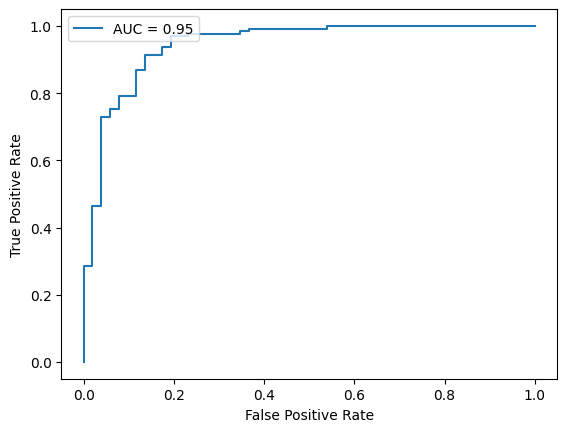

In [ ]:
# ROC and AUC
fig, ax = plt.subplots(1,3)

RocCurveDisplay.from_estimator(svc, testX, testY, name="SVM", ax=ax[0])
ax[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

RocCurveDisplay.from_estimator(rf, testX, testY, name="random forest", ax=ax[1])
ax[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

RocCurveDisplay.from_estimator(lr, testX, testY, name="logistic regression", ax=ax[2])
ax[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")